# Packages

In [1]:
# Helpful packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload
import split_vectorize
import base_models
import neural_nets

from IPython.display import display, HTML

# Get Data

Choose how many rows of data you want to work with by filling in the n value below.

In [2]:
n = 10000

Uncomment the line below to create a new data file with a random sample of `n` articles. Otherwise, skip to the next cell to import an existing file with `n` articles.

In [3]:
# %run parse_corpus.py $n

In [3]:
df = pd.read_csv('data/nyt_corpus_'+str(n)+'.csv')
df.shape
df.head()

,abstract,author_info,copyright_holder,copyright_year,descriptor,desk,full_text,general_descriptor,headline,id,...,print_page_number,print_section,publication_day_of_month,publication_day_of_week,publication_month,publication_year,series_name,taxonomic_classifier,title,types_of_material
0,NaN,NaN,The New York Times,1992.0,NaN,Financial Desk,"The Bethlehem Steel Corporation, after report...","['Layoffs and Job Reductions', 'Labor']",Bethlehem Halts Dividends And Plans Cuts After...,504309,...,1.0,D,30.0,Thursday,1.0,1992.0,NaN,['Top/News/Business'],Bethlehem Halts Dividends And Plans Cuts After...,NaN
1,NaN,NaN,The New York Times,1996.0,NaN,Foreign Desk,Seeking to raise morale at home and improve i...,"['Elections', 'Politics and Government']",World News Briefs;Iraqis Elect Parliament Pre-...,839267,...,5.0,A,25.0,Monday,3.0,1996.0,NaN,"['Top/News', 'Top/News/World/Countries and Ter...",World News Briefs;Iraqis Elect Parliament Pre-...,NaN
2,Editorial urges British Museum to approach Pa...,NaN,The New York Times,2002.0,"['Christians and Christianity', 'Art']",Editorial Desk,By the time Lord Elgin obtained the authority...,"['Games', 'Sculpture', 'Archaeology and Anthro...",Return the Parthenon Marbles,1364306,...,18.0,A,2.0,Saturday,2.0,2002.0,NaN,"['Top/Opinion', 'Top/Opinion/Opinion', 'Top/Op...",Return the Parthenon Marbles,['Editorial']
3,NaN,NaN,The New York Times,2002.0,NaN,Classified,SPEIER-Claire. Born New York City. Age 70. Gr...,NaN,"Paid Notice: Deaths SPEIER, CLAIRE",1404294,...,15.0,C,28.0,Friday,6.0,2002.0,NaN,['Top/Classifieds/Paid Death Notices'],"Paid Notice: Deaths SPEIER, CLAIRE",['Paid Death Notice']
4,NaN,NaN,The New York Times,1988.0,NaN,National Desk,LEAD: The Japanese videotape begins with the ...,"['Recordings (Audio)', 'Recordings (Video)', '...",Not Fit to Import?,130413,...,8.0,B,25.0,Friday,3.0,1988.0,WASHINGTON TALK: BRIEFING,"['Top/News/U.S.', 'Top/Features/Travel/Guides/...",Not Fit to Import?,NaN


### Possible Model Outputs

There are multiple columns that could be used as the target variable in classification models. I will use `desk` since it has the lowest percentage of nulls and it never assigns multiple labels to an article.

In [4]:
df[['desk','general_descriptor','online_sections','taxonomic_classifier']][-5:]

,desk,general_descriptor,online_sections,taxonomic_classifier
9995,Editorial Desk,NaN,Opinion,"['Top/Opinion/Opinion/Letters', 'Top/Opinion',..."
9996,National Desk,NaN,U.S.,"['Top/News/U.S.', 'Top/News']"
9997,Metropolitan Desk,NaN,New York and Region,['Top/News/New York and Region']
9998,Classified,NaN,Paid Death Notices,['Top/Classifieds/Paid Death Notices']
9999,Leisure/Weekend Desk,NaN,Arts,['Top/Features/Arts']


Percentage of nulls for each of the possible label columns:

In [5]:
(n - df[['desk','general_descriptor','online_sections','taxonomic_classifier']].count()) / n

desk                    0.0041
general_descriptor      0.2140
online_sections         0.0244
taxonomic_classifier    0.0144
dtype: float64

# Preprocess Data

Uncomment the line below to run pre-processing on the parsed data file. Otherwise, skip to the next cell to import the existing preprocessed file.

In [53]:
# %run preprocessing.py $n

Imported data file
Cleaned 1000 entries in full_text
Cleaned 2000 entries in full_text
Cleaned 3000 entries in full_text
Cleaned 4000 entries in full_text
Cleaned 5000 entries in full_text
Cleaned 6000 entries in full_text
Cleaned 7000 entries in full_text
Cleaned 8000 entries in full_text
Cleaned 9000 entries in full_text
Cleaned 10000 entries in full_text
Cleaned full_text
Cleaned 1000 entries in lead_paragraph
Cleaned 2000 entries in lead_paragraph
Cleaned 3000 entries in lead_paragraph
Cleaned 4000 entries in lead_paragraph
Cleaned 5000 entries in lead_paragraph
Cleaned 6000 entries in lead_paragraph
Cleaned 7000 entries in lead_paragraph
Cleaned 8000 entries in lead_paragraph
Cleaned 9000 entries in lead_paragraph
Cleaned 10000 entries in lead_paragraph
Cleaned lead_paragraph
Cleaned 1000 entries in headline
Cleaned 2000 entries in headline
Cleaned 3000 entries in headline
Cleaned 4000 entries in headline
Cleaned 5000 entries in headline
Cleaned 6000 entries in headline
Cleaned 70

In [54]:
df_final = pd.read_csv('data/nyt_corpus_cleaned_'+str(n)+'.csv')
print(df_final.shape)
df_final.head()

(10000, 6)


,desk,full_text,lead_paragraph,headline,nouns,lemmas
0,business & financial,"the bethlehem steel corporation , after report...","the bethlehem steel corporation , after report...",bethlehem halts dividends and plans cuts after...,bethlehem steel corporation loss quarter yeste...,"the bethlehem steel corporation , after report..."
1,foreign,seeking to raise morale at home and improve it...,seeking to raise morale at home and improve it...,world news briefs ; iraqis elect parliament pr...,morale home image iraq today elections candida...,seek to raise morale at home and improve it im...
2,editorial,by the time lord elgin obtained the authority ...,by the time lord elgin obtained the authority ...,return the parthenon marbles,time lord elgin authority pieces stone inscrip...,by the time lord elgin obtain the authority to...
3,classified,speier - claire . born new york city . age 70....,speier - claire . born new york city . age 70....,"paid notice : deaths speier , claire",claire york city age graduate york university ...,speier - claire . born new york city . age 70....
4,national,lead : the japanese videotape begins with the ...,lead : the japanese videotape begins with the ...,not fit to import ?,lead videotape words tables foods tape inspect...,lead : the japanese videotape begin with the w...


The table below shows some examples of how I cleaned up the `desk` variable.

In [9]:
label_transform = pd.concat([df_final.desk, df.desk], axis=1)
label_transform.columns = ['desk_cleaned', 'desk']
label_transform.groupby(['desk_cleaned','desk']).size().reset_index(name='cnt').set_index(['desk_cleaned','desk'])[:20]

cnt
desk_cleaned         desk                                      
a nation challenged  A Nation Challenged                      1
arts & leisure       Arts & Ideas/Cultural Desk              18
                     Arts & Leisure Desk                     29
                     Arts and Leisure Desk                  129
                     Cultural Desk                          231
                     Leisure/Weekend Desk                    56
                     Movies, Performing Arts/Weekend Desk    80
                     Museums                                  1
                     The Arts/Cultural Desk                 219
                     Weekend Desk                           115
                     Weekend DeskWeekend Desk                 4
book review          Book Review Desk                       176
business & financial Business World Magazine                  1
                     Business/Finance Desk                    1
                     Business/Financial Desk                628
                     Business\Financial Desk                  1
                     E-Commerce                               1
                     Financial Desk                        1106
                     Financial Desk;                          2
                     Money and Business/Financial Desk       79

### Train/Dev/Test Split and TF-IDF Vectorize

Here I create an object for each model input:

1. Full text
2. Lead paragraph
3. Headlines
4. Nouns
5. Lemmas

Throughout the rest of notebook, I will attach various statistics and models to each object.

/Users/carmen/Documents/NLP/w266-final-project/split_vectorize.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = self.df[[self.articles, self.labels]][self.df[self.articles].notnull()][self.df[self.labels].notnull()]


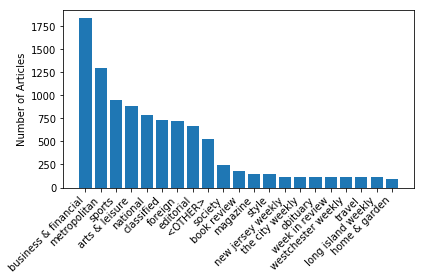

In [72]:
reload(split_vectorize)
rand_seed = 102 # Random number to feed in so all models will assign same articles to train/dev/test sets

# Create object for each of the model inputs
full_text = split_vectorize.SplitVectorize(df_final, 'full_text', 'Full Text')
lead_para = split_vectorize.SplitVectorize(df_final, 'lead_paragraph', 'Lead Paragraph')
headlines = split_vectorize.SplitVectorize(df_final, 'headline', 'Headlines')
nouns = split_vectorize.SplitVectorize(df_final, 'nouns', 'Nouns Only')
lemmas = split_vectorize.SplitVectorize(df_final, 'lemmas', 'Lemmatized')

all_inputs = [full_text, lead_para, headlines, nouns, lemmas]

# Split into train/test data and TF-IDF vectorize
for x in all_inputs:
    x.train_test_split(rand_seed)
    x.tfidf_vectorize()

Percentage of articles NOT in the `<OTHER>` category:

In [27]:
for x in all_inputs:
    print('{}: {:.1%}'.format(x.name_, x.df[x.df.desk != '<OTHER>'].groupby('desk').count().sum()[0] / x.df.groupby('desk').count().sum()[0]))

Full Text: 94.7%
Lead Paragraph: 94.6%
Headlines: 94.8%
Nouns Only: 94.8%
Lemmatized: 94.8%


Key statistics for each type of data. Note the number of articles for each model input varies because sometimes certain inputs have missing data. However, the same articles are assigned to training/dev/test data for each input.

In [56]:
html = '<table><th>Article Type</th><th>Total Articles</th><th>Training Articles</th><th>Training Words</th><th>% Training Words</th>'
html += '<th>Avg. Words per Training Article</th><th>Training Vocab Size</th><th>% Training Vocab</th>'
html += '<th>Avg. Unique Words per Training Article</th><th>Dev Articles</th><th>Test Articles</th></tr>'

for x in all_inputs:
    total = x.tv_train.shape[0] + x.tv_dev.shape[0] + x.tv_test.shape[0]
    html += '<tr><td>{}</td><td>{:,}</td><td>{:,}</td><td>{:,}</td>'.format(x.name_, total, x.tv_train.shape[0], x.train_words_)
    html += '<td>{:.0%}</td><td>{:.0f}</td>'.format(x.train_words_/full_text.train_words_, x.train_avg_words_)
    html += '<td>{:,}</td><td>{:.0%}</td>'.format(x.train_vocab_size_, x.train_vocab_size_/full_text.train_vocab_size_)
    html += '<td>{:,.0f}</td><td>{:,}</td><td>{:,}</td></tr>'.format(x.train_avg_unq_words_, x.tv_dev.shape[0], x.tv_test.shape[0])

html += '</table>'
display(HTML(html))

Full Text,"9,847","7,356","5,032,755",100%,684,"87,541",100%,264,513,"1,978"
Lead Paragraph,"9,590","7,169","740,321",15%,103,"40,309",46%,61,499,"1,922"
Headlines,"9,997","7,459","57,752",1%,8,"11,150",13%,6,516,"2,022"
Nouns Only,"9,845","7,354","1,349,489",27%,184,"64,998",74%,112,513,"1,978"
Lemmatized,"9,847","7,356","5,032,755",100%,684,"75,648",86%,245,513,"1,978"


# Baseline Models

I use a Multinomial Naïve Bayes and Logistic Regression as simple baseline models. For each model and model input, I fit multiple models with different parameters values, and then optimize on the dev data. After finding the best models, I calculate the accuracy on the test data.

### Multinomial Naïve Bayes

Fit multiple MNB models on each of the model inputs, looking for the best value of `alpha`.

In [73]:
reload(base_models)
mnb = base_models.MultNB()

for x in all_inputs:
    mnb.test_models(x)

Graph the accuracy on the dev data for each of the models tested.

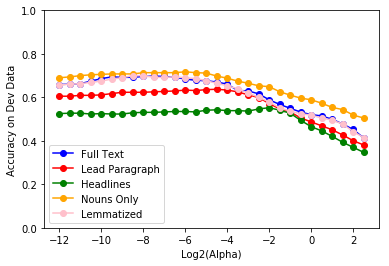

In [74]:
mnb_tables = []
for x in all_inputs:
    mnb_tables.append(x.mnb_accuracy_table_)

mnb.plot_accuracy(mnb_tables)

### Logistic Regression

Fit multiple LR models on each of the model inputs, looking for the best values of `C` and `penalty`.

In [63]:
reload(base_models)
lr = base_models.LogReg()

for x in all_inputs:
    lr.test_models(x)

Graph the accuracy on the dev data for each of the models tested.

Best Logistic Regression model:
input         Full Text
penalty              L2
C          100.00000000
accuracy     0.77192982
Name: 23, dtype: object


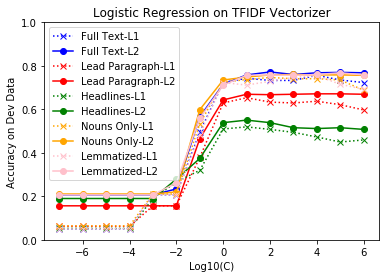

In [64]:
lr_tables = []
for x in all_inputs:
    lr_tables.append(x.lr_accuracy_table_)

lr.plot_accuracy(lr_tables)

### Key Statistics

For the best MNB and LR models for each of the possible inputs.

In [66]:
html = '<table><th>Model Input</th><th>MNB Parameters</th><th>MNB Dev Accuracy</th><th>MNB Test Accuracy</th>'
html += '<th>LR Parameters</th><th>LR Dev Accuracy</th><th>LR Test Accuracy</th>'

for x in all_inputs:
    alpha = 'alpha = 2^'+str(np.log2(x.best_mnb_model_.alpha))
    html += '<tr><td>{}</td><td>{}</td><td>{:.3f}</td><td>{:.3f}</td>'.format(x.name_, alpha, max(x.mnb_accuracy_table_.accuracy), x.best_mnb_model_.score(x.tv_test, x.test_labels))
    C = 'C = 10^'+str(np.log10(x.best_lr_model_.C))
    penalty = 'penalty = '+x.best_lr_model_.penalty
    html += '<td>{}</td><td>{:.3f}</td><td>{:.3f}</td></tr>'.format(C+'; '+penalty, max(x.lr_accuracy_table_.accuracy), x.best_lr_model_.score(x.tv_test, x.test_labels))

html += '</table>'
display(HTML(html))

Full Text,alpha = 2^-7.5,0.698,0.693,C = 10^2.0; penalty = l2,0.772,0.742
Lead Paragraph,alpha = 2^-4.5,0.637,0.624,C = 10^4.0; penalty = l2,0.671,0.661
Headlines,alpha = 2^-2.0,0.552,0.502,C = 10^1.0; penalty = l2,0.550,0.545
Nouns Only,alpha = 2^-6.0,0.717,0.664,C = 10^3.0; penalty = l2,0.760,0.702
Lemmatized,alpha = 2^-8.5,0.700,0.685,C = 10^5.0; penalty = l2,0.768,0.743


# Neural Network

1. This model uses GloVe word embeddings to initialize the word embedding matrix.
2. For each of the model inputs, it drops the bottom ***20%*** of words, since these tend to be misspellings or one-off words that don't contribute to helping the model learn the structure of each category.
3. For each of the model inputs, it pads each article to the smaller of:
    + The ***90th*** percentile of lengths for that input type
    + 500

In [123]:
reload(neural_nets)
nn = neural_nets.NeuralNets()
nn.load_glove_vectors()

for x in all_inputs:
    nn.tokenize(x)
    nn.pad(x)

# Num Tokens:
# Drop 10%: 1238, 138, 11, 381, 1236
# Drop 20%: 1234, 137, 10, 375, 1232

# Padding:
#  90%: 1241,  140, 11,  381, 1236
# 100%: 7555, 5974, 55, 3296, 7556

Loaded GloVe matrix of 100-dimensional embeddings for 400,000 words.
Full Text:
+ Training vocab size: 70,033
+ 90th percentile of length = 1,234 --> inputs padded to 500.
+ Vocab reduced to 54,814 by padding operation (-22%)
+ Training data shape: (7356, 500)
Lead Paragraph:
+ Training vocab size: 32,247
+ 90th percentile of length = 137 --> inputs padded to 137.
+ Vocab reduced to 28,113 by padding operation (-13%)
+ Training data shape: (7169, 137)
Headlines:
+ Training vocab size: 8,920
+ 90th percentile of length = 10 --> inputs padded to 10.
+ Vocab reduced to 8,660 by padding operation (-3%)
+ Training data shape: (7459, 10)
Nouns Only:
+ Training vocab size: 51,998
+ 90th percentile of length = 373 --> inputs padded to 373.
+ Vocab reduced to 49,192 by padding operation (-5%)
+ Training data shape: (7354, 373)
Lemmatized:
+ Training vocab size: 60,518
+ 90th percentile of length = 1,234 --> inputs padded to 500.
+ Vocab reduced to 45,811 by padding operation (-24%)
+ Training d

In [113]:
nn.neural_net(full_text)
#for x in all_inputs:
    #nn.neural_net(x)

Compiled
Epoch 1/5
7356/7356 [==============================] - 14s 2ms/step - loss: 2.2961 - acc: 0.3559
Epoch 2/5
7356/7356 [==============================] - 14s 2ms/step - loss: 1.6495 - acc: 0.5461
Epoch 3/5
7356/7356 [==============================] - 14s 2ms/step - loss: 1.3681 - acc: 0.6234
Epoch 4/5
7356/7356 [==============================] - 14s 2ms/step - loss: 1.1872 - acc: 0.6703
Epoch 5/5
7356/7356 [==============================] - 14s 2ms/step - loss: 1.0504 - acc: 0.7096
Fit
1978/1978 [==============================] - 0s 85us/step
Test loss: 5.534420794495678
Test accuracy: 0.09555106169729671
First prediction (probabilities): [7.5132990e-01 4.9912534e-04 1.1594447e-03 8.1591743e-08 1.0598532e-02
 1.9947186e-02 3.4817625e-03 1.2498809e-04 1.6870843e-04 1.7663908e-01
 1.1852604e-03 5.1416378e-03 1.1244091e-03 4.3262835e-03 4.5397643e-05
 2.6234266e-06 5.9554093e-03 7.8924159e-03 1.9051983e-03 6.7809643e-03
 1.6916040e-03]
First prediction (category): 0
First test labe

In [120]:
nn.neural_net(headlines)

Compiled
Epoch 1/5
7459/7459 [==============================] - 1s 167us/step - loss: 2.1579 - acc: 0.3940
Epoch 2/5
7459/7459 [==============================] - 1s 125us/step - loss: 1.5279 - acc: 0.5674
Epoch 3/5
7459/7459 [==============================] - 1s 127us/step - loss: 1.2861 - acc: 0.6288
Epoch 4/5
7459/7459 [==============================] - 1s 132us/step - loss: 1.1127 - acc: 0.6853
Epoch 5/5
7459/7459 [==============================] - 1s 161us/step - loss: 0.9575 - acc: 0.7343
Fit
2022/2022 [==============================] - 0s 65us/step
Test loss: 6.211659965835858
Test accuracy: 0.07764589515331355
First prediction (probabilities): [5.0002422e-02 7.9539837e-04 5.0701234e-03 2.8936252e-06 2.5100713e-03
 1.2159178e-02 6.1319890e-03 2.6813404e-05 5.8568624e-04 7.7225077e-01
 8.1880367e-04 4.0977020e-03 1.1018749e-02 1.1468193e-02 1.2244362e-05
 8.3140872e-09 4.0686391e-02 5.0376332e-03 4.8088543e-02 2.5895372e-02
 3.3410818e-03]
First prediction (category): 9
First test

### Key Statistics

In [126]:
html = '<table><th>Model Input</th><th>Training Vocab</th><th>Padding Size</th>'
html += '<th>Vocab After Padding</th><th>Test Accuracy</th>'

for x in all_inputs:
    html += '<tr><td>{}</td><td>{:,}</td><td>{:,}</td>'.format(x.name_, x.train_vocab_size_ * 0.8, x.train_ids.shape[1])
    html += '<td>{:.3f}</td></tr>'.format(x.nn_accuracy_)

html += '</table>'
display(HTML(html))

AttributeError: 'SplitVectorize' object has no attribute 'nn_accuracy_'

# Error Analysis

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
for x in [full_text]:#, lead_para, headlines, nouns, lemmas]:
    print('\n', x.name_, ':')
    print(classification_report(x.dev_labels, x.best_mnb_model_.predict(x.tv_dev)))
    print(confusion_matrix(x.dev_labels, x.best_mnb_model_.predict(x.tv_dev), labels=list(x.dev_labels.unique())))

In [ ]:
x.dev_labels.unique()